In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, r2_score, mean_absolute_error, mean_squared_error, silhouette_score
import warnings
warnings.filterwarnings('ignore')
from prophet import Prophet

**LOAD DATASET**

In [5]:
dataset = pd.read_csv("/content/daily-min-temperatures.csv")
dataset.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [6]:
dataset.columns = ['ds', 'y']
dataset['ds'] = pd.to_datetime(dataset['ds'])

In [7]:
dataset['ds'].min(), dataset['ds'].max()

(Timestamp('1981-01-01 00:00:00'), Timestamp('1990-12-31 00:00:00'))

In [8]:
trainset = dataset[dataset['ds'].dt.year < 1989]
validset = dataset[dataset['ds'].dt.year == 1989]
testset = dataset[dataset['ds'].dt.year == 1990]

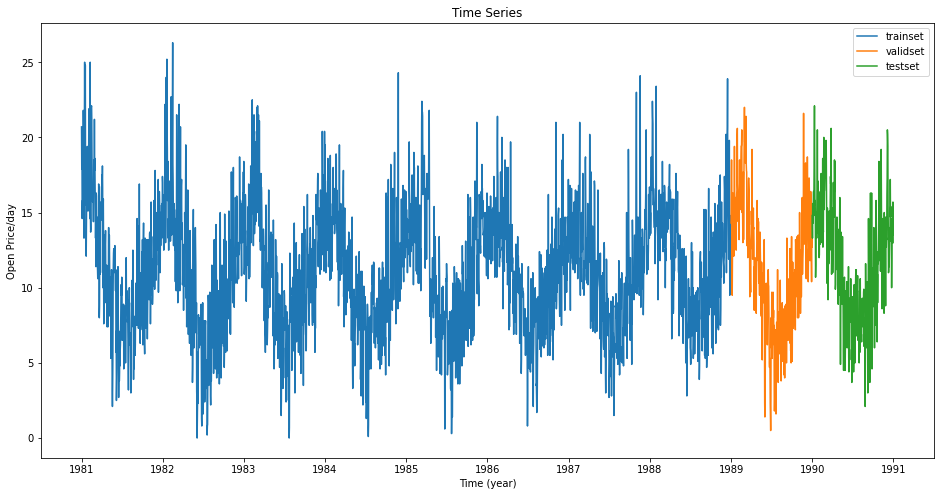

In [10]:
a = trainset.set_index('ds')
b = validset.set_index('ds')
c = testset.set_index('ds')
plt.figure(figsize= (16, 8))
plt.plot(a['y'], label= "trainset")
plt.plot(b['y'], label= "validset")
plt.plot(c['y'], label= "testset")
plt.title("Time Series")
plt.xlabel("Time (year)")
plt.ylabel("Open Price/day")
plt.legend(loc= 'best')

In [ ]:
# unoptimized 
prophet = Prophet(yearly_seasonality= True, daily_seasonality= False, weekly_seasonality= False)
prophet.fit(trainset)

In [12]:
train_pred = prophet.predict(trainset[['ds']])['yhat']
valid_pred = prophet.predict(validset[['ds']])['yhat']
test_pred = prophet.predict(testset[['ds']])['yhat']

In [13]:
print('RMSE trainset adalah {}'.format(mean_squared_error(trainset['y'], train_pred, squared=False)))
print('RMSE validset adalah {}'.format(mean_squared_error(validset['y'], valid_pred, squared=False)))
print('RMSE testset adalah {}'.format(mean_squared_error(testset['y'], test_pred, squared=False)))

RMSE trainset adalah 2.749221889121302
RMSE validset adalah 2.884166999005635
RMSE testset adalah 2.946479838267663


In [ ]:
# optimized yearly_seasonality
par = [10, 20, 50, 100]
train = []
valid = []
a = []
for x in par:
    prophet_cv = Prophet(yearly_seasonality=x)
    
    prophet_cv.fit(trainset)

    train_pred = prophet_cv.predict(trainset[['ds']])['yhat']
    valid_pred = prophet_cv.predict(validset[['ds']])['yhat'] 

    train.append(mean_squared_error(trainset['y'], train_pred, squared=False))
    valid.append(mean_squared_error(validset['y'], valid_pred, squared=False))
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

In [16]:
a[np.argmin(valid)]

20

In [ ]:
# optimized changepoint_prior_scale
par = [0.01, 0.05, 0.1, 1]
train = []
valid = []
a = []
for x in par:
    prophet_cv = Prophet(changepoint_prior_scale=x,
                                   yearly_seasonality=20)
    
    prophet_cv.fit(trainset)

    train_pred = prophet_cv.predict(trainset[['ds']])['yhat']
    valid_pred = prophet_cv.predict(validset[['ds']])['yhat'] 

    train.append(mean_squared_error(trainset['y'], train_pred, squared=False))
    valid.append(mean_squared_error(validset['y'], valid_pred, squared=False))
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

In [19]:
a[np.argmin(valid)]

0.01

In [ ]:
# optimized weekly_seasonality
par = [10, 20, 50, 100]
train = []
valid = []
a = []
for x in par:
    prophet_cv = Prophet(weekly_seasonality=x,
                                   yearly_seasonality=20,
                                   changepoint_prior_scale = 0.01)
    
    prophet_cv.fit(trainset)

    train_pred = prophet_cv.predict(trainset[['ds']])['yhat']
    valid_pred = prophet_cv.predict(validset[['ds']])['yhat'] 

    train.append(mean_squared_error(trainset['y'], train_pred, squared=False))
    valid.append(mean_squared_error(validset['y'], valid_pred, squared=False))
    a.append(x)
    
sns.lineplot(x = a, y=train, label='train')
sns.lineplot(x = a, y=valid, label='valid')
plt.show()

In [22]:
a[np.argmin(valid)]

100

In [28]:
forecast_opt = Prophet(changepoint_prior_scale=0.01, yearly_seasonality=20, weekly_seasonality= 100)

In [29]:
forecast_opt.fit(trainset)
train_predopt = forecast_opt.predict(trainset[['ds']])['yhat']
valid_predopt = forecast_opt.predict(validset[['ds']])['yhat']
test_predopt = forecast_opt.predict(testset[['ds']])['yhat']

In [31]:
# tanpa tunning 
print('RMSE trainset adalah {}'.format(mean_squared_error(trainset['y'], train_pred, squared=False)))
print('RMSE validset adalah {}'.format(mean_squared_error(validset['y'], valid_pred, squared=False)))
print('RMSE testset adalah {}'.format(mean_squared_error(testset['y'], test_pred, squared=False)))

RMSE trainset adalah 2.7433051711935956
RMSE validset adalah 2.6345984708340966
RMSE testset adalah 2.946479838267663


In [32]:
# dengan tunning
print('RMSE trainset opt adalah {}'.format(mean_squared_error(trainset['y'], train_predopt, squared=False)))
print('RMSE validset opt adalah {}'.format(mean_squared_error(validset['y'], valid_predopt, squared=False)))
print('RMSE testset opt adalah {}'.format(mean_squared_error(testset['y'], test_predopt, squared=False)))

RMSE trainset opt adalah 2.7433051711935956
RMSE validset opt adalah 2.6345984708340966
RMSE testset opt adalah 2.554350779157584


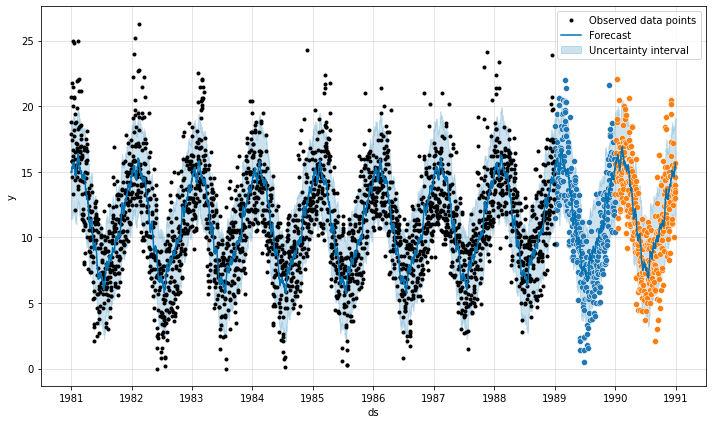

In [33]:
forecast_opt.plot(forecast_opt.predict(dataset[['ds']]))
sns.scatterplot(data=validset, x='ds', y='y')
sns.scatterplot(data=testset, x='ds', y='y')
plt.show()

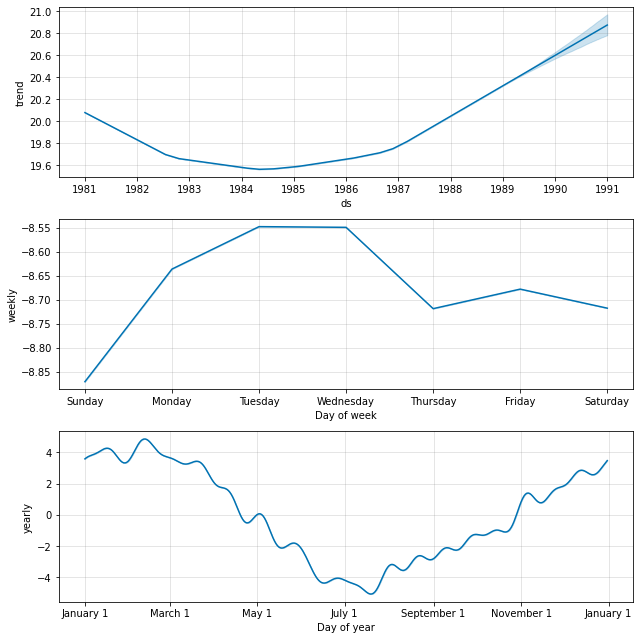

In [34]:
forecast_opt.plot_components(forecast_opt.predict(dataset[['ds']]))
plt.show()

**Predict 5 tahun kedepan**

In [49]:
future = prophet.make_future_dataframe(periods= 365*8)
future = future[(future['ds'].dt.year >= 1991) & (future['ds'].dt.year <= 1995)]

In [50]:
future.tail()

,ds
5472,1995-12-27
5473,1995-12-28
5474,1995-12-29
5475,1995-12-30
5476,1995-12-31


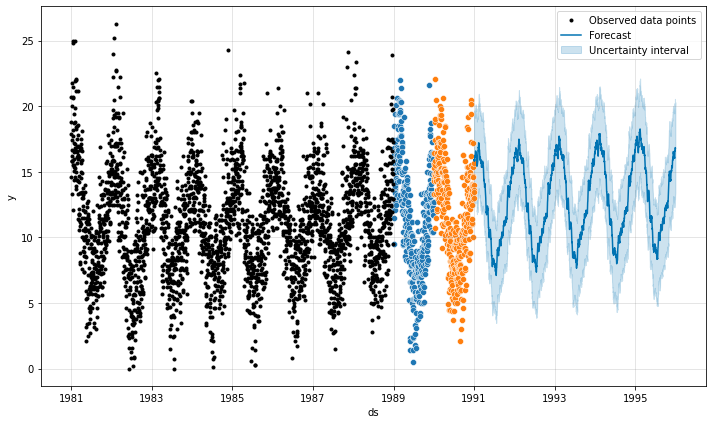

In [52]:
forecast_opt.plot(forecast_opt.predict(future[['ds']]))
sns.scatterplot(data=validset, x='ds', y='y')
sns.scatterplot(data=testset, x='ds', y='y')
plt.show()

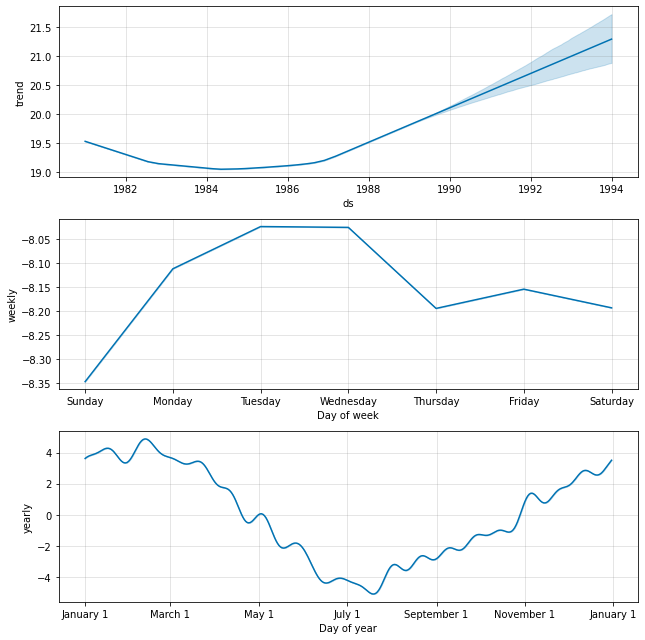

In [ ]:
forecast_opt.plot_components(forecast_opt.predict(future))
plt.show()